# Pytorch
Installation: https://pytorch.org/get-started/locally/

Documentation: https://pytorch.org/docs/stable/index.html

In [454]:
import sys
print(f'Using python version {sys.version}') # get python version

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Using python version 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


# Downloading data:

# Loading and examining data

In [455]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

In [456]:
print (f'Training/Valid data shape: {X_train_valid.shape}')
print (f'Training/Valid labels shape: {y_train_valid.shape}')

Training/Valid data shape: (2115, 22, 1000)
Training/Valid labels shape: (2115,)


Text(0, 0.5, 'count')

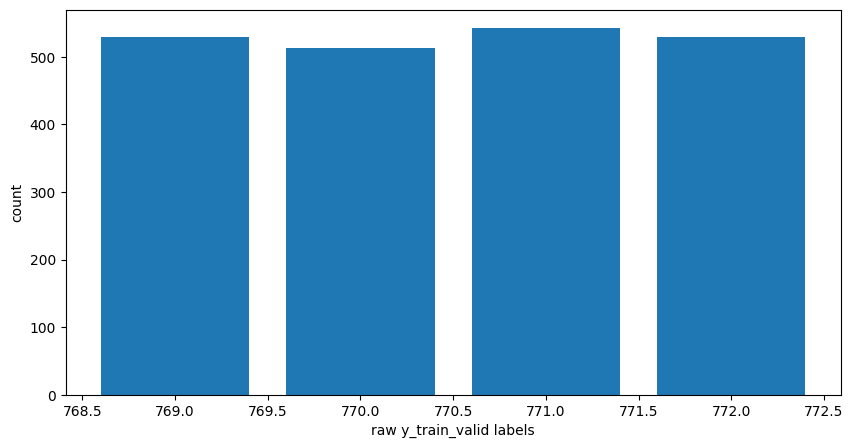

In [457]:
plt.figure(figsize=(10, 5))
plt.bar(*np.unique(y_train_valid, return_counts=True))
plt.xlabel('raw y_train_valid labels')
plt.ylabel('count')

In [458]:
# Convert to 0-4 labeling and integer type (integers needed for categorical labels)
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')

# Modules

In [459]:
# inherits from nn.Module
class ShallowConvNet(nn.Module):
    def __init__(self, input_shape=(22, 1000), n_temporal_filters=40, n_spatial_filters=40, n_classes=4):
        super().__init__() # call __init__ method of superclass
        
        self.input_shape = input_shape # last two dimensions, (excluding batch size). Should be length 2.
        self.n_temporal_filters = n_temporal_filters
        self.n_spatial_filters = n_spatial_filters
        self.n_classes = n_classes

        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.temporal_convolution = nn.Conv2d(1, n_temporal_filters, (1, 25))

        # We could implement the spatial convolution as a 1d, or 2d, or 3d convolution.
        # We use 2d here.
        self.spatial_convolution = nn.Conv2d(n_temporal_filters, n_spatial_filters, (input_shape[0], 1))

        self.average_pool = nn.AvgPool2d((1, 75), stride=(1, 15))

        # Final linear layer
        self.n_dense_features = n_spatial_filters*(1 + ((input_shape[1] - 25 + 1) - 75) // 15)
        self.dense = nn.Linear(self.n_dense_features, n_classes)
        # you can also use 'self.dense = nn.LazyLinear(n_classes)' to avoid having to manually compute features

        self.elu = nn.ELU()
        return
    
    # declaring a forward method also makes the instance a callable.
    # e.g.:
    # model = ShallowConvNet()
    # out = model(x)
    def forward(self, x):
        # x has shape (batch_size, input_shape[0], input_shape[1])
        # Let H0 = input_shape[0], H1 = input_shape[1]
        h = x

        # note that h.view(-1, 1, h.shape[1], h.shape[2]) works normally but does not work with torchinfo
        # this is because the torchinfo input has a weird shape
        h = h.view(-1, 1, self.input_shape[0], self.input_shape[1]) # view as (batch_size, 1, input_shape[0], input_shape[1])
        # Sometimes, view doesn't work and you have to use reshape. This is because of how tensors are stored in memory.

        # 2d convolution takes inputs of shape (batch_size, num_channels, H, W)
        h = self.temporal_convolution(h) # (batch_size, 1, H0, W0) -> (batch_size, n_temporal_filters, H0, W0 - 25 + 1)
        h = self.elu(h)

        h = self.spatial_convolution(h) # (batch_size, n_temporal_filters, H0, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, W0 - 25 + 1)
        h = self.elu(h)

        h = h**2 # square
        # alternatively, use torch.pow(h, 2.0)

        h = self.average_pool(h) # (batch_size, n_spatial_filters, 1, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, 1 + ((W0 - 25 + 1) - 75)//15)

        h = torch.log(h) # (natural) log

        h = h.view(h.shape[0], -1) # flatten the non-batch dimensions
        h = self.dense(h) # (batch_size, self.n_dense_features) -> (batch_size, n_classes)

        return h



# Summarizing modules

In [460]:
from torchinfo import summary
# Only uses outputs of modules.
print(summary(ShallowConvNet(), input_size=(22, 1000)))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet                           [1, 4]                    --
├─Conv2d: 1-1                            [1, 40, 22, 976]          1,040
├─ELU: 1-2                               [1, 40, 22, 976]          --
├─Conv2d: 1-3                            [1, 40, 1, 976]           35,240
├─ELU: 1-4                               [1, 40, 1, 976]           --
├─AvgPool2d: 1-5                         [1, 40, 1, 61]            --
├─Linear: 1-6                            [1, 4]                    9,764
Total params: 46,044
Trainable params: 46,044
Non-trainable params: 0
Total mult-adds (M): 56.73
Input size (MB): 0.09
Forward/backward pass size (MB): 7.18
Params size (MB): 0.18
Estimated Total Size (MB): 7.46


# Using GPUs with pytorch

In [461]:
# See https://pytorch.org/docs/stable/notes/cuda.html
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
# device_id =  'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 

True


In [462]:
print(torch.zeros(4).cuda().device)
print(torch.zeros(4).to(device).device)
print(torch.zeros(4).to('cpu').device)

cuda:0
cuda:0
cpu


# Creating a dataset and dataloader

In [463]:
import numpy as np
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 1.0         # Sample Period
fs = 1000.0       # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 5       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff = cutoff, fs = fs, order = order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff=butter, fs=fs, order=order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff=cutoff, fs=fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [464]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)
print(X_train_np.shape)

# X_train_np = np.array([ butter_highpass_filter(x)   for x in X_train_np ])
# X_val_np = np.array([ butter_highpass_filter(x)   for x in X_val_np ])

# offsets = np.random.random_integers(1, 10, size=(X_train_np.shape[0], 5, 2))

# print(X_train_np.shape)
# print(offsets.shape)
# print(X_train_np[0].shape)

# X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], X_train_np.shape[2] // 4))
# X_val_np.reshape((X_train_np.shape[0], X_train_np.shape[1], X_val_np.shape[2] // 4))

# new_X_train = [*X_train_np]
# new_y_train = [*y_train_np]

# new_X_train = []
# new_y_train = []

# for i, ofs in enumerate(offsets):
#     for o, oo in ofs:
#         new_X_train.append(np.roll(np.roll(X_train_np[i], o, 1), oo, 0))
#         new_y_train.append(y_train_np[i])

# new_X_train = np.array(new_X_train)
# new_y_train = np.array(new_y_train)

# print(new_X_train.shape)
# print(new_y_train.shape)

t_start = 0
t_end = 400
t_step = 1
t_size = int(np.ceil((t_end - t_start) / t_step))
n_crops = 5
t_crop = 50
X_train_np = np.vstack([X_train_np[:, :, t_start+i*t_crop:t_end+i*t_crop:t_step] for i in np.arange(n_crops)])
y_train_np = np.hstack([y_train_np for i in np.arange(n_crops)])
# X_val_np = X_val_np[:, :, t_start:t_end:t_step]

X_mean = np.mean(X_train_np, axis=2)
X_val_mean = np.mean(X_val_np, axis=2)

# X_train_np -= X_mean[:, :, np.newaxis]
# X_val_np -= X_val_mean[:, :, np.newaxis]

# X_train = torch.FloatTensor(new_X_train).to(device)
X_train = torch.FloatTensor(X_train_np).to(device)
X_val = torch.FloatTensor(X_val_np).to(device)
# y_train = torch.LongTensor(new_y_train).to(device)
y_train = torch.LongTensor(y_train_np).to(device)
y_val = torch.LongTensor(y_val_np).to(device)

print(X_train_np.shape)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)

(1692, 22, 1000)
(8460, 22, 400)
torch.Size([8460, 22, 400])
torch.Size([423, 22, 1000])
torch.Size([8460])


In [465]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [466]:
batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

In [467]:
len(train_dataset), len(train_dataloader)

(8460, 133)

# Training a model

In [468]:
import tqdm # for progress bar

In [469]:
# # Set the random seeds.
# # Sometimes some operations are not deterministic.
# # See https://pytorch.org/docs/stable/notes/randomness.html
# #   and https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
# import random
# torch.manual_seed(12345) # set the random seed for pytorch
# random.seed(12345) # just in case
# np.random.seed(12345) # just in case

# model = ShallowConvNet((22, len(X_train[0][0]))).to(device)
# # For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
# #   or implement it manually and add it to the loss before backward propagation.

# # Declare an optimizer that handles weight updates
# # This optimizer also has its own state dictionary
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-2)
# celoss = nn.CrossEntropyLoss()

# loss_hist = []
# val_loss_hist = []
# acc_hist = []
# val_acc_hist = []

In [470]:
# num_epochs = 20


# # progress bar
# pbar = tqdm.tqdm(
#     range(num_epochs), position=0, leave=True,
#     bar_format='{l_bar}{bar:30}{r_bar}',
# )
# for epoch in pbar:
#     model.train() # set model to training mode.
#     for batch in train_dataloader:
#         optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
#         x, y = batch

#         # x = x.to(device) # necessary if X is not on the same device as model
#         # y = y.to(device)

#         out = model(x) # shape (batch_size, n_classes)
#         loss = celoss(out, y) # calculate the cross entropy loss

#         loss.backward() # backpropagate
#         optimizer.step() # perform optimization step

#         # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
#         # Otherwise you will run out of memory.
#         # You MUST use .item() to convert to a scalar or call .detach().
#         loss_hist.append(loss.item())
    
#     model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
#     # calculate accuracy for training and validation sets
#     ns = 0 # number of samples
#     nc = 0 # number of correct outputs
#     with torch.no_grad():
#         for batch in train_dataloader:
#             x, y = batch
#             out = model(x)
#             ns += len(y)
#             nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
#     acc_hist.append(nc/ns)

#     ns = 0 # number of samples
#     nc = 0 # number of correct outputs
#     with torch.no_grad():
#         for batch in val_dataloader:
#             x, y = batch
#             out1 = model(x[:, :, 0:400])
#             out2 = model(x[:, :, 50:450])
#             out3 = model(x[:, :, 100:500])
#             out4 = model(x[:, :, 150:550])
#             out5 = model(x[:, :, 200:600])
#             out = (out1 + out2 + out3 + out4 + out5) / 5
#             loss = celoss(out, y)
#             val_loss_hist.append(loss.item())
#             ns += len(y)
#             nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
#     val_acc_hist.append(nc/ns)


#     # update progress bar postfix
#     pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

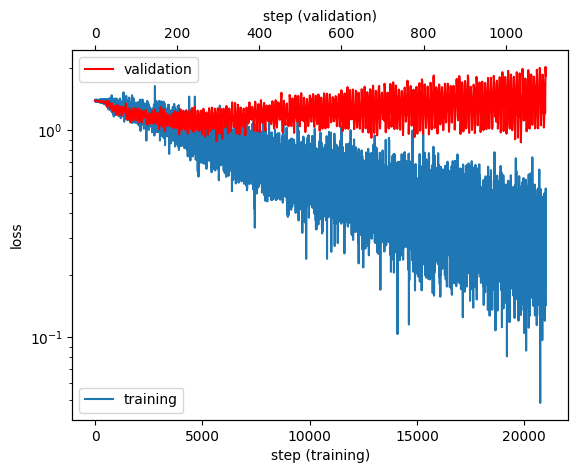

In [471]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

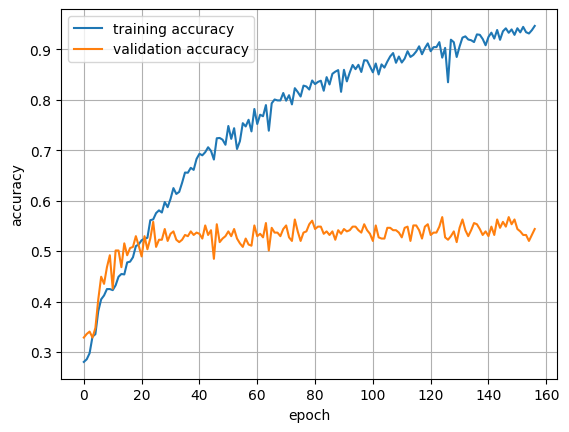

In [472]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()

# Saving models

#RNN

In [473]:
class AlexNet(nn.Module):
    def __init__(self, input_dim=22, output_dim=4):
        super(AlexNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.f1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()

        self.c2 = nn.Conv1d(128, 64, 3)

        self.p2 = nn.MaxPool1d(2)
        self.d2 = nn.Dropout(0.5)

        self.r3 = nn.LSTM(64, 32, batch_first=True, num_layers=1)
        self.f4 = nn.Linear(32, output_dim)

    def forward(self, x, h_0=None):
        # x has shape (batch_size, input_dim, timesteps)
        # h_0 has shape (D*num_layers, hidden_dim)

        # print(x.shape)
        # print(x.shape)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        x = self.f1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1) # (batch_size, timesteps, input_dim) -> (batch_size, input_dim, timesteps)

        x = self.c2(x)
        x = self.relu(x)
        x = self.p2(x)
        x = self.d2(x)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        
        if h_0 is None:
            x, hn = self.r3(x) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        else:
            # We detach h_0 (not required, just recommended) so that the computational graph does not extend too far.
            x, hn = self.r3(x, h_0) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        # hn is the stored hidden state after computation
        x = self.f4(x[:, -1, :])
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.fc3(x)
        return x

In [486]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim=22, hidden_dim=64, n_spatial_filters=40, output_dim=4):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # self.norm = nn.LayerNorm(input_dim)
        self.a1 = nn.AvgPool1d(4)
        # self.fc0 = nn.Linear(22, 64)
        # self.a1 = nn.Conv1d(input_dim, input_dim, 4, 4)
        # self.a2 = nn.Conv1d(input_dim, input_dim, 2, 2)
        self.d = nn.Dropout1d(0.25)
        self.conv1 = nn.Conv1d(input_dim, 32, 2, padding='same')
        self.h1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, 2, padding='same')
        self.h2 = nn.ReLU()
        self.conv3 = nn.Conv1d(64, 128, 2, padding='same')
        self.h3 = nn.ReLU()
        # self.conv4 = nn.Conv1d(128, 256, 2, padding='same')
        # self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(128, 98)
        self.h4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.rnn = nn.LSTM(98, hidden_dim, batch_first=True, num_layers=1, bidirectional=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h_0=None):
        # x has shape (batch_size, input_dim, timesteps)
        # h_0 has shape (D*num_layers, hidden_dim)

        # print(x.shape)
        # print(x.shape)

        x = self.a1(x)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        x = self.d(x)
        # x = self.fc0(x)
        # x = self.norm(x)
        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)


        # x = self.relu(x)
        # x = self.a2(x)
        # x = self.relu(x)
        
        x = self.conv1(x)
        x = self.h1(x)

        x = self.conv2(x)
        x = self.h2(x)

        x = self.conv3(x)
        x = self.h3(x)
        # x = self.conv4(x)
        # x = self.relu(x)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.h4(x)

        if h_0 is None:
            x, hn = self.rnn(x) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        else:
            # We detach h_0 (not required, just recommended) so that the computational graph does not extend too far.
            x, hn = self.rnn(x, h_0) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        # hn is the stored hidden state after computation
        x = self.fc2(x[:, -1, :])
        # x = self.dropout(x)
        return x

In [489]:
# Note that sometimes RNNs run faster on cpu, but usually only if they're small.
#device = torch.device('cpu')

model = RNNClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [490]:
from torchinfo import summary
print(summary(model, input_size=(22, t_size), batch_dim=0))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [AvgPool1d: 1, Dropout1d: 1, Conv1d: 1, ReLU: 1, Conv1d: 1, ReLU: 1, Conv1d: 1, ReLU: 1, Linear: 1, Dropout: 1, ReLU: 1, LSTM: 1]

In [491]:
num_epochs = 260

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch

        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step

        # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
        # Otherwise you will run out of memory.
        # You MUST use .item() to convert to a scalar or call .detach().
        loss_hist.append(loss.item())
    
    model.eval() # set model to evaluation mode.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            outs = torch.from_numpy(
                np.array(
                    [model(x[:, :, t_start+i*t_crop:t_end+i*t_crop:t_step]).cpu().numpy() for i in np.arange(n_crops)]
                )
            ).to(device)
            out = torch.mean(outs, axis=0)
            loss = celoss(out, y)
            val_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

  0%|                              | 0/260 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 64x4)

In [478]:
# Best to use .pt for file extensions
# I used to think .pth was used, but it turns out it can have potential conflicts with python
#   (See https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch)

# Save only the model weights
i += 1
torch.save(model.state_dict(), f'rnn_{i}_weightsonly.pt')

# Save an entire checkpoint
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss_hist': loss_hist,
    'acc_hist': acc_hist,
    'val_loss_hist': val_loss_hist,
    'val_acc_hist': val_acc_hist,
}
torch.save(checkpoint, f'rnn_{i}_checkpoint.pt')

In [479]:
chkpt = torch.load(f'rnn_{i}_checkpoint.pt')
loss_hist = chkpt['loss_hist']
acc_hist = chkpt['acc_hist']
val_loss_hist = chkpt['val_loss_hist']
val_acc_hist = chkpt['val_acc_hist']

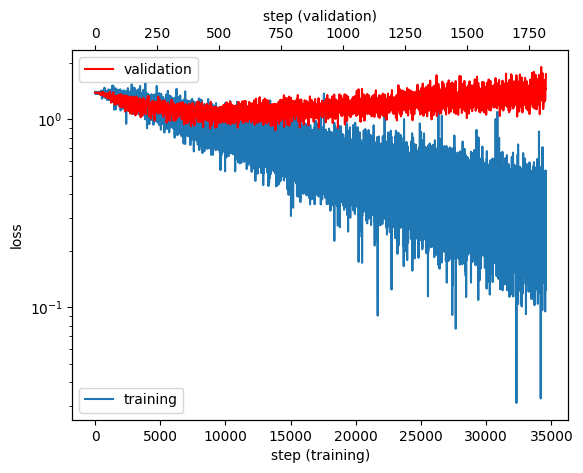

In [484]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

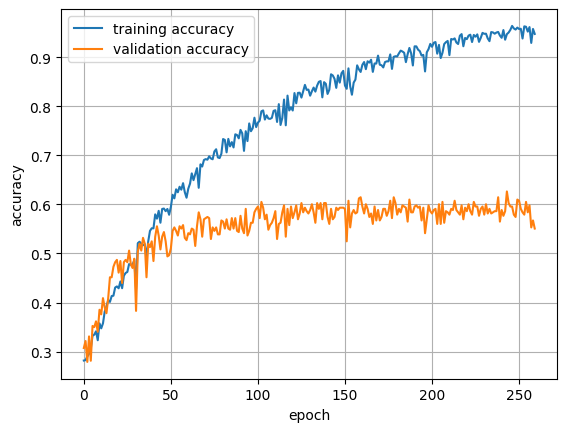

In [485]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()

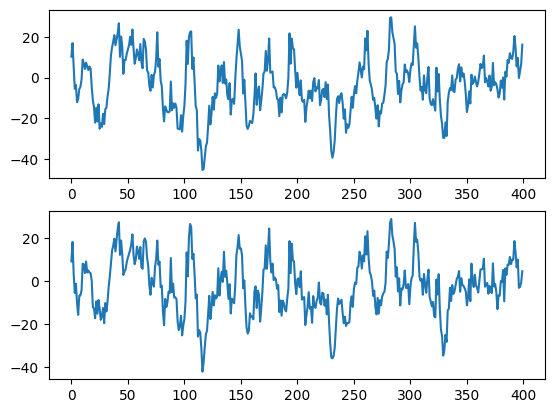

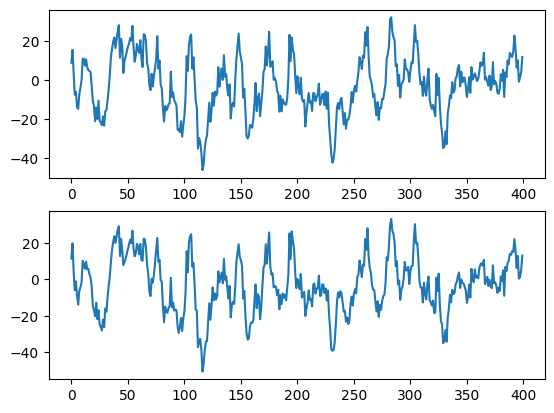

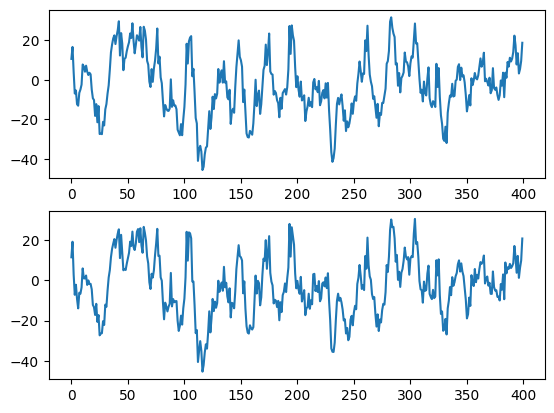

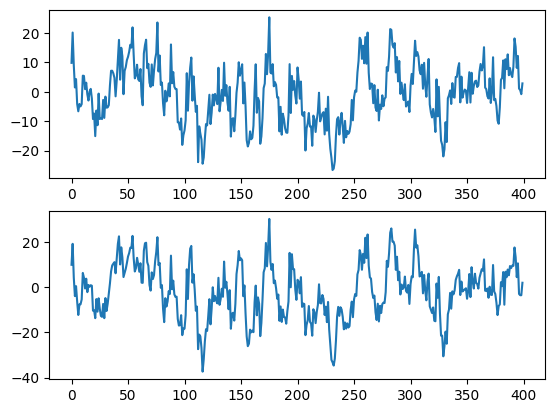

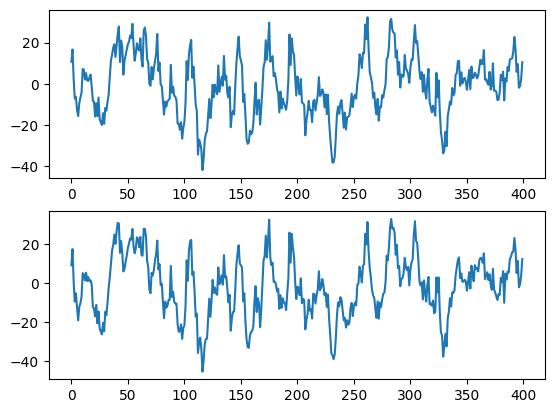

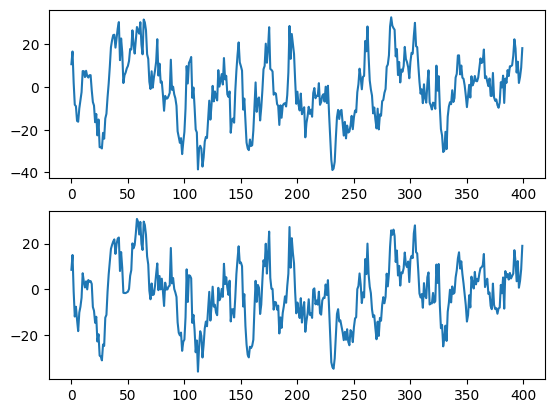

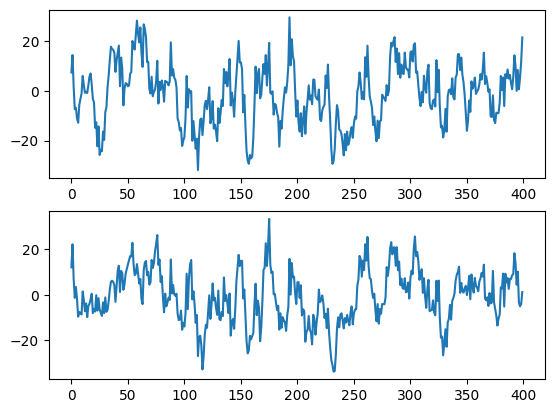

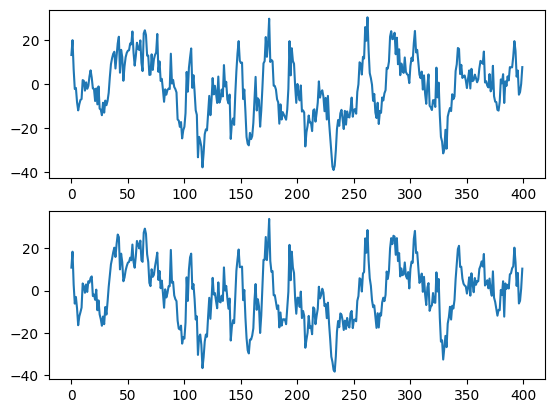

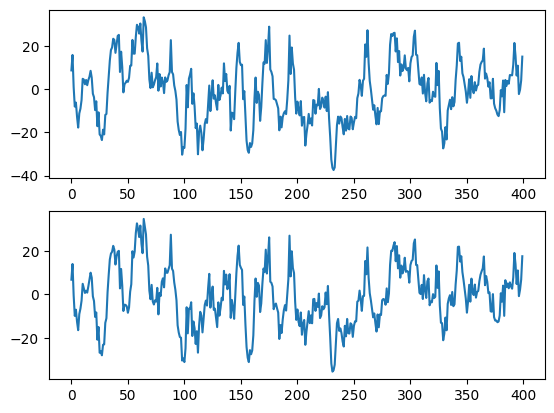

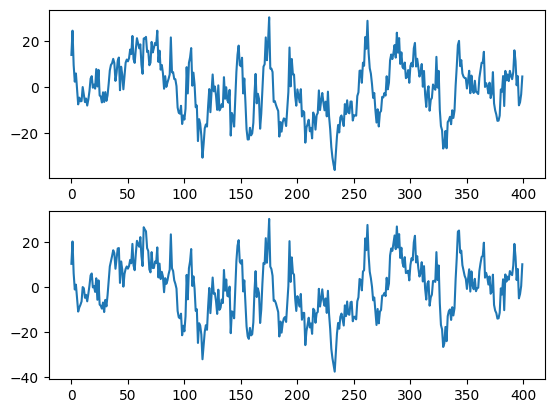

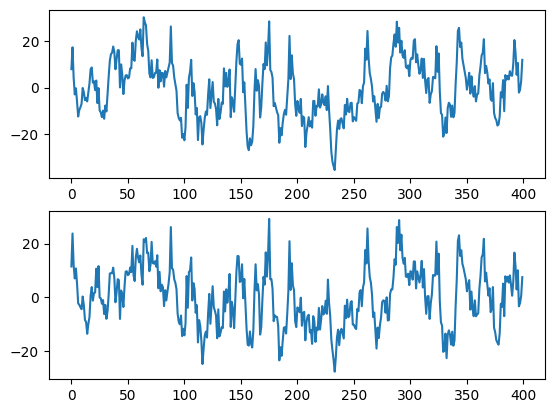

In [482]:


for o in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    fig, axs = plt.subplots(2)
    for i, axs in enumerate(axs):
        d = X_train[0][o + i].cpu().numpy()
        d = d
        axs.plot(np.arange(len(d)), d)

In [483]:
i=0